In [5]:
import pandas as pd
import numpy as np
import time
import requests
import os.path
import re
import math
import io
from datetime import timedelta
from fractions import Fraction
import statsmodels.formula.api as sm
from bs4 import BeautifulSoup, Comment
from sklearn.neighbors.kde import KernelDensity
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from selenium import webdriver
#driver = webdriver.Chrome('/Users/dylanfarrell/Desktop/Thesis/chromedriver')
import matplotlib.pyplot as plt

In [6]:
# Misc Functions
def is_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [26]:
# Scraping Functions
# Player data functions
def get_players(pos,yr):
    link = (
            'https://www.pro-football-reference.com/play-index/psl_finder.cgi?request=1&match=single&year_min='
            +str(yr)+'&year_max='+str(yr)+'&season_start=1&season_end=-1&season_start=1&season_end=-1&league_id=NFL'
            +'&is_active=Y&pos%5B%5D='+pos+'&draft_year_min=1936&draft_year_max=2019&draft_slot_min=1'
            +'&draft_slot_max=500&draft_pick_in_round=pick_overall&conference=any&draft_pos%5B%5D=qb'
            +'&draft_pos%5B%5D=rb&draft_pos%5B%5D=wr&draft_pos%5B%5D=te&draft_pos%5B%5D=e&draft_pos%5B%5D=t'
            +'&draft_pos%5B%5D=g&draft_pos%5B%5D=c&draft_pos%5B%5D=ol&draft_pos%5B%5D=dt&draft_pos%5B%5D=de'
            +'&draft_pos%5B%5D=dl&draft_pos%5B%5D=ilb&draft_pos%5B%5D=olb&draft_pos%5B%5D=lb&draft_pos%5B%5D=cb'
            +'&draft_pos%5B%5D=s&draft_pos%5B%5D=db&draft_pos%5B%5D=k&draft_pos%5B%5D=p&c1stat=g&c1comp=gt&c1val=1&order_by=g'
    )
    soup = BeautifulSoup(requests.get(link).text, "lxml")
    rows = soup.find('table', id = 'results').find('tbody').find_all('tr', class_=lambda x: x != 'thead')
    urls = [tr.findChildren(['th','td'])[1].a['href'] for tr in rows]
    return urls

def scrape(player):
    stem = 'https://www.pro-football-reference.com'
    link = stem+player[0:-4]+'/gamelog/'
    soup = BeautifulSoup(requests.get(link).text, "lxml")
    rows = soup.find(id = 'div_stats').find('table').find('tbody').find_all('tr', class_ = lambda x: x != 'thead')
    headers = [x['data-stat'] for x in rows[0].find_all(['th','td'])]
    df = pd.DataFrame([[td.contents[0] if len(td.contents)==1 else td.contents for td in tr.findChildren(['th', 'td'])] for tr in rows], columns = headers)
    time.sleep(1)
    return df 

def run_scraper(players,d):
    count = 0
    for player in players:
        d[player] = scrape(player)
        count += 1
        if count % 10 == 0:
            print str(count)+" players scraped"
            
def save_scrapes(pos_dict, pos, folder):
    for player in pos_dict.keys():
        name = folder+'/'+pos+'/'+str(player.replace('/',''))+'.csv'
        pos_dict[player].to_csv(name,encoding = 'utf-8',index=False)
        
def load_scrapes(pos_dict,pos_set, pos, folder):
    for player in pos_set:
        name = folder+'/'+pos+'/'+str(player.replace('/',''))+'.csv'
        pos_dict[player] = pd.read_csv(name)
        

#Game data functions
def get_game_var(game_info,var):
    try:
        return [x.contents[1].text for x in game_info if var in x.contents[0].text][0]
    except:
        return ''

def clean_vegas(team,opp,vegas):
    if opp in vegas:
        favorite = 'Opponent'
        line = float(vegas.replace(opp,''))
    elif team in vegas:
        favorite = 'Team'
        line = float(vegas.replace(team,''))
    elif 'Pick' in vegas:
        favorite = 'Pick'
        line = 0.0
    else:
        raise Exception('Bad vegas line: '+vegas)
    return (favorite,line)

def clean_over(over):
    return float(over.replace('(over)','').replace('(under)','').replace('(push)',''))

def remove_list(s,lst):
    for l in lst:
        s = s.replace(l,'')
    return s

def check_list(s,lst):
    for l in lst:
        if l not in s:
            return False
    return True

def get_weather_var(weather,var):
    var_list = var.split(' ')
    try:
        return [float(remove_list(x,var_list)) for x in weather.split(',') if check_list(x,var_list)][0]
    except:
        return 'NA'

def clean_weather(weather):
    degrees = get_weather_var(weather,'degrees')
    wind = get_weather_var(weather,'wind mph')
    wind_chill = get_weather_var(weather,'wind chill')
    relative_humidity = get_weather_var(weather,'relative humidity')
    return (degrees,wind,wind_chill,relative_humidity)

def get_team_name(team_href):
    team_url = 'https://www.pro-football-reference.com'+team_href
    team_soup = BeautifulSoup(requests.get(team_url).text, 'lxml')
    return team_soup.find('div',{'data-template':'Partials/Teams/Summary'}).find_all('span')[1].contents[0]

def extract_href(href_col):
    try:
        return href_col['href']
    except:
        start = href_col.find('href')+6
        end = href_col.find('.htm')+4
        return href_col[start:end]

In [8]:
yrs = range(2011,2019)
all_qbs = {}
all_rbs = {}
all_wrs = {}
all_tes = {}

for yr in yrs:
    print 'Year :'+str(yr)
    print 'Starting QBs'
    all_qbs[yr] = get_players('qb',yr)
    print 'Starting RBs'
    all_rbs[yr] = get_players('rb',yr)
    print 'Starting WRs'
    all_wrs[yr] = get_players('wr',yr)
    print 'Starting TEs'
    all_tes[yr] = get_players('te',yr)

Year :2011
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2012
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2013
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2014
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2015
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2016
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2017
Starting QBs
Starting RBs
Starting WRs
Starting TEs
Year :2018
Starting QBs
Starting RBs
Starting WRs
Starting TEs


In [9]:
wrs = set()
rbs = set()
qbs = set()
tes = set()

for yr in yrs:
    wrs = wrs|set(all_wrs[yr])
    rbs = rbs|set(all_rbs[yr])
    qbs = qbs|set(all_qbs[yr])
    tes = tes|set(all_tes[yr])

In [10]:
wr_dict = {}
rb_dict = {}
qb_dict = {}
te_dict = {}

In [65]:
print "Scraping qbs..."
run_scraper(qbs,qb_dict)
time.sleep(20)
print "Scraping wrs..."
run_scraper(wrs,wr_dict)
time.sleep(20)
print "Scraping rbs..."
run_scraper(rbs,rb_dict)
time.sleep(20)
print "Scraping tes..."
run_scraper(tes,te_dict)
time.sleep(20)
print "Done scraping!"

Scraping qbs...
10 players scraped
20 players scraped
30 players scraped
40 players scraped
50 players scraped
60 players scraped
70 players scraped
Scraping wrs...
10 players scraped
20 players scraped
30 players scraped
40 players scraped
50 players scraped
60 players scraped
70 players scraped
80 players scraped
90 players scraped
100 players scraped
110 players scraped
120 players scraped
130 players scraped
140 players scraped
150 players scraped
Scraping rbs...
10 players scraped
20 players scraped
30 players scraped
40 players scraped
50 players scraped
60 players scraped
70 players scraped
80 players scraped
90 players scraped
100 players scraped
110 players scraped
120 players scraped
130 players scraped
Scraping tes...
10 players scraped
20 players scraped
30 players scraped
40 players scraped
50 players scraped
60 players scraped
70 players scraped
80 players scraped
90 players scraped
100 players scraped
110 players scraped
Done scraping!


In [19]:
# save raw data
save_scrapes(qb_dict,'qbs','raw_data')
save_scrapes(wr_dict,'wrs','raw_data')
save_scrapes(rb_dict,'rbs','raw_data')
save_scrapes(te_dict,'tes','raw_data')

In [11]:
# load raw data
load_scrapes(qb_dict,qbs,'qbs','raw_data')
load_scrapes(wr_dict,wrs,'wrs','raw_data')
load_scrapes(rb_dict,rbs,'rbs','raw_data')
load_scrapes(te_dict,tes,'tes','raw_data')

In [ ]:
## want to get fantasy points project based on all other starters
# for each other starter, how many points does rb on same team score, e.g. (probably time-weighted average)
# this step may take extensive time
#     star_headers = ['Player','Pos']
#     try:
#         home_starts = soup.find('div', id = 'all_home_starters').findAll(text=lambda text:isinstance(text, Comment))[0]
#         home_soup = BeautifulSoup(home_starts,'lxml')
#         rows_star = home_soup.find('table').find('tbody').find_all('tr')
#         home_starters = pd.DataFrame([[td.contents[0] if len(td.contents)==1 else td.contents for td in tr.find_all(['td','th'])] for tr in rows_star], columns = star_headers)

#         vis_starts = soup.find('div', id = 'all_vis_starters').findAll(text=lambda text:isinstance(text, Comment))[0]
#         vis_soup = BeautifulSoup(vis_starts,'lxml')
#         rows_vis = vis_soup.find('table').find('tbody').find_all('tr')
#         vis_starters = pd.DataFrame([[td.contents[0] if len(td.contents)==1 else td.contents for td in tr.find_all(['td','th'])] for tr in rows_vis], columns = star_headers)

#         if player in list(home_starters['Player'].map(lambda x : x['href'])):
#             start.append(1)
#         elif player in list(vis_starters['Player'].map(lambda x : x['href'])):
#             start.append(1)
#         else :
#             start.append(0)
#     except (KeyboardInterrupt, SystemExit):
#         raise
#     except:
#         start.append(0.5)
                
    #external_points_projection.append(10)

In [28]:
def game_scraper(player,dct,folder):
    day_col = []
    time_col = []
    stadium_col = []
    att_col = []
    dome_col = []
    surface_col = []
    favorite_col = []
    line_col = []
    weather_col = []
    over_col = []
    degrees_col = []
    wind_col = []
    wind_chill_col = []
    relative_humidity_col = []

    def game_scrape(row,player): 
        url = 'https://www.pro-football-reference.com'+extract_href(row['game_date'])
        print url
        soup = BeautifulSoup(requests.get(url).text, 'lxml')

        score_info = soup.find('div', class_ = 'scorebox_meta').find_all('div')

        day_col.append(score_info[0].contents[0].split(' ')[0])
        time_col.append(score_info[1].contents[1].replace(': ',''))
        stadium_col.append(score_info[2].find('a').contents[0])
        att_col.append(int(score_info[3].find('a').contents[0].replace(',','')))

        game_info_comment = soup.find('div', id = 'all_game_info').findAll(text=lambda text:isinstance(text, Comment))[0]
        game_info_soup = BeautifulSoup(game_info_comment,'lxml')        
        game_info = game_info_soup.find('table').find_all('tr')

        dome_col.append(get_game_var(game_info,'Roof'))
        surface_col.append(get_game_var(game_info,'Surface'))
        team = get_team_name(extract_href(row['team']))
        opp = get_team_name(extract_href(row['opp']))
        vegas = get_game_var(game_info,'Vegas Line')
        (favorite,line) = clean_vegas(team,opp,vegas)
        favorite_col.append(favorite)
        line_col.append(line)
        over_col.append(clean_over(get_game_var(game_info,'Over/Under')))
        weather = get_game_var(game_info,'Weather')
        (degrees,wind,wind_chill,relative_humidity) = clean_weather(weather)
        degrees_col.append(degrees)
        wind_col.append(wind)
        wind_chill_col.append(wind_chill)
        relative_humidity_col.append(relative_humidity)

    for i in range(len(dct[player])):
        #try:
            game_scrape(dct[player].iloc[i],player)
        #except:
        #    raise Exception('Problem with player: '+player+', row: '+str(i))
            
    dct[player]['Day'] = day_col
    dct[player]['Time'] = time_col
    dct[player]['Stadium'] = stadium_col
    dct[player]['Att'] = att_col
    dct[player]['Dome'] = dome_col
    dct[player]['Surface'] = surface_col
    dct[player]['Favorite'] = favorite_col
    dct[player]['Line'] = line_col
    dct[player]['Over/Under'] = over_col
    dct[player]['Degrees'] = degrees_col
    dct[player]['Wind'] = wind_col
    dct[player]['Wind Chill'] = wind_chill_col
    dct[player]['Relative Humidity'] = relative_humidity_col
        
    dct[player].to_csv(folder+str(player.replace('/',''))+'.csv',encoding = 'utf-8',index=False)
    
    

In [13]:
rbs = list(rbs)
qbs = list(qbs)
tes = list(tes)
wrs = list(wrs)

In [29]:
def run_game_scrapes(players,player_dct,folder):
    player_count = 0
    for player in players:
        if os.path.isfile(folder+player.replace('/','')+'.csv'):
            print 'Already scraped: '+player
        else:
            print 'Now scraping: '+player
            game_scraper(player,player_dct,folder)
            print 'Done scraping: '+player+'!'
            time.sleep(5)
        player_count+=1
        print str(len(players)-player_count)+' players remaining'

In [30]:
#print 'Starting qbs'
#run_game_scrapes(qbs, qb_dict,'raw_data_game_scrapes/qbs/')
#print 'Starting rbs'
#run_game_scrapes(rbs, rb_dict,'raw_data_game_scrapes/rbs/')
print 'Starting wrs'
run_game_scrapes(wrs, wr_dict,'raw_data_game_scrapes/wrs/')
#print 'Starting tes'
#run_game_scrapes(tes, te_dict,'raw_data_game_scrapes/tes/')


Starting wrs
Already scraped: /players/W/WestDe00.htm
158 players remaining
Already scraped: /players/R/RidlCa00.htm
157 players remaining
Already scraped: /players/N/NatsJo00.htm
156 players remaining
Already scraped: /players/P/ParkDe01.htm
155 players remaining
Already scraped: /players/S/SandEm00.htm
154 players remaining
Already scraped: /players/P/PerrBr02.htm
153 players remaining
Already scraped: /players/L/LouiRi00.htm
152 players remaining
Already scraped: /players/E/EvanMi00.htm
151 players remaining
Already scraped: /players/W/WillNi02.htm
150 players remaining
Already scraped: /players/D/DiggSt00.htm
149 players remaining
Already scraped: /players/I/InmaDo00.htm
148 players remaining
Already scraped: /players/B/BrowDa04.htm
147 players remaining
Already scraped: /players/R/RichPa01.htm
146 players remaining
Already scraped: /players/P/PryoTe00.htm
145 players remaining
Already scraped: /players/A/AndeRo04.htm
144 players remaining
Already scraped: /players/C/CartDe02.htm
1

KeyboardInterrupt: 

In [13]:
tes = list(set(tes))
qbs = list(set(qbs))
rbs = list(set(rbs))
wrs = list(set(wrs))

In [122]:
def add_points(row):
    def pull_fpoints_stat(row,stat):
        try:
            s = float(row[stat])
            if math.isnan(s):
                return 0.0
            else:
                return s
        except:
            return 0.0
    return (
            pull_fpoints_stat(row,'pass_yds')*0.04
            +pull_fpoints_stat(row,'pass_td')*4.0
            +pull_fpoints_stat(row,'pass_int')*(-2.0)
            +pull_fpoints_stat(row,'rush_yds')*.1
            +pull_fpoints_stat(row,'rush_td')*6
            +pull_fpoints_stat(row,'rec_yds')*.1
            +pull_fpoints_stat(row,'rec_td')*6
            +pull_fpoints_stat(row,'rec')*1
    )

def clean_game_scrapes(df):
    df['started'] = df['gs'].map(lambda x: x == '*')
    df['df_time'] = df['Time'].map(lambda t: 
                                     int(t[-2:] == 'pm')*12
                                     +int(t.split(':')[0])
                                     +int(t[:-2].split(':')[1])/60.0
                                    )
    df['outdoors'] = df['Dome'].map(lambda x: 'outdoors' in x)
    df['turf'] = df['Surface'].map(lambda x: 'turf' in x)
    df['away'] = df['game_location'].map(lambda x: x == '@')
    df['fpoints'] = df.apply(add_points,axis = 1)
    df = df.applymap(lambda x: x if x != '[]' else 0)
    return df
    #df['spread'] = df[] --convert favorite to 1,-1 and then multiply by line

In [91]:
### Read in data if not loaded

for qb in qbs:
    try:
        qb_dict[qb] = clean_game_scrapes(pd.read_csv('raw_data_game_scrapes/qbs/'+qb.replace('/','')+'.csv'))
    except:
        print 'Could not find data for: '+str(qb)

for rb in rbs:
    try:
        rb_dict[rb] = clean_game_scrapes(pd.read_csv('raw_data_game_scrapes/rbs/'+rb.replace('/','')+'.csv'))
    except:
        print 'Could not find data for: ' +str(rb)
                                            
for wr in wrs:
    try:
        wr_dict[wr] = clean_game_scrapes(pd.read_csv('raw_data_game_scrapes/wrs/'+wr.replace('/','')+'.csv'))
    except:
        print 'Could not find data for: ' +str(wr)
# for te in tes:
#     try:
#         te_dict[te] = clean_game_scrapes(pd.read_csv('raw_data_game_scrapes/tes/'+te.replace('/','')+'.csv'))
#     except:
#         b_te.append(te)


Could not find data for: /players/C/ColeCo00.htm
Could not find data for: /players/B/BellJo02.htm
Could not find data for: /players/A/AmenDa00.htm
Could not find data for: /players/H/HiggRa00.htm
Could not find data for: /players/A/AustTa00.htm
Could not find data for: /players/P/PeakCh00.htm
Could not find data for: /players/C/CobbRa00.htm
Could not find data for: /players/J/JoneT.00.htm
Could not find data for: /players/A/AdamDa01.htm
Could not find data for: /players/M/MaylVi00.htm
Could not find data for: /players/C/CrowJa00.htm
Could not find data for: /players/W/WilsAl02.htm
Could not find data for: /players/G/GibsSh00.htm
Could not find data for: /players/M/MoorD.00.htm
Could not find data for: /players/H/HollMa00.htm
Could not find data for: /players/K/KearJe01.htm
Could not find data for: /players/S/SlatMa00.htm
Could not find data for: /players/J/JohnCh08.htm
Could not find data for: /players/H/HarrDw00.htm
Could not find data for: /players/C/CrabMi00.htm
Could not find data 

In [693]:
def get_last_n(newlst,lst,n):
    newlst = newlst+[float('nan')]*n
    for i in range(n,len(lst)):
        x = lst[i-n-1:i-1]
        newlst.append(sum(x)/n)
    return newlst

def fpts_a(db,n):
    if len(db['FPoints']) <= n:
        return [float('nan')]*len(db['FPoints'])
    else:
        fpts_avgs = []
        fpts_avgs = get_last_n(fpts_avgs,db['FPoints'],n)
    return fpts_avgs
    #db['FPoints_A'] = fpts_avgs
    

In [694]:
# set num weeks to be incldued in avg
n = 4
for qb in qbs:
    qb_dict[qb]['FPoints_4'] = fpts_a(qb_dict[qb],n)

for rb in rbs:
    rb_dict[rb]['FPoints_4'] = fpts_a(rb_dict[rb],n)
for wr in wrs:
    wr_dict[wr]['FPoints_4'] = fpts_a(wr_dict[wr],n)

In [695]:
n = 10
for qb in qbs:
    qb_dict[qb]['FPoints_10'] = fpts_a(qb_dict[qb],n)

for rb in rbs:
    rb_dict[rb]['FPoints_10'] = fpts_a(rb_dict[rb],n)
for wr in wrs:
    wr_dict[wr]['FPoints_10'] = fpts_a(wr_dict[wr],n)

In [87]:
qbs = list(qbs)
wrs = list(wrs)
rbs = list(rbs)

In [651]:
##beta delta discounting:
##compute correlation from one game to next
x = []
y = []
for qb in qbs:
    for i in range(len(qb_dict[qb]['FPoints'])-1):
        x.append(qb_dict[qb]['FPoints'].iloc[i])
        y.append(qb_dict[qb]['FPoints'].iloc[i+1])

In [657]:
np.corrcoef(x,y)

array([[ 1.        ,  0.45946933],
       [ 0.45946933,  1.        ]])

In [88]:
def get_avgs(db,pos):
    cmp_p_a = []
    att_p_a = []
    yds_p_a = []
    tds_p_a = []

    fpts_a = []

    att_r_a = []
    yds_r_a = []
    tds_r_a = []

    rec_w_a = []
    tgt_w_a = []
    yds_w_a = []
    tds_w_a = []

    for i in range(1,len(db['Year'])+1):
        if pos == 'qb':
            cmp_p_a.append(db['Cmp_P'][:i].apply(float).mean())
            att_p_a.append(db['Att_P'][:i].apply(float).mean())
            yds_p_a.append(db['Yds_P'][:i].apply(float).mean())
            tds_p_a.append(db['TD_P'][:i].apply(float).mean())
        if pos in ['qb','rb']:
            att_r_a.append(db['Att_R'][:i].apply(float).mean())
            yds_r_a.append(db['Yds_R'][:i].apply(float).mean())
            tds_r_a.append(db['TD_R'][:i].apply(float).mean())
                
        if pos in ['rb','wr']:
            rec_w_a.append(db['Rec_W'][:i].apply(float).mean())
            tgt_w_a.append(db['Tgt_W'][:i].apply(float).mean())
            yds_w_a.append(db['Yds_W'][:i].apply(float).mean())
            tds_w_a.append(db['TD_W'][:i].apply(float).mean()) 
                
        fpts_a.append(db['FPoints'][:i].apply(float).mean())

    if pos == 'qb':
        db['Cmp_P_A'] = cmp_p_a
        db['Att_P_A'] = att_p_a
        db['Yds_P_A'] = yds_p_a
        db['TD_P_A'] = tds_p_a
    if pos in ['qb','rb']:
        db['Att_R_A'] = att_r_a
        db['Yds_P_A'] = yds_r_a
        db['TD_P_A'] = tds_r_a

    db['FPoints_A'] = fpts_a
    if pos in ['rb','wr']:
        db['Rec_W_A'] = rec_w_a
        db['Yds_W_A'] = yds_w_a
        db['TD_W_A'] = tds_w_a
        db['Tgt_P_A'] = tgt_w_a

In [89]:
#add avgs
for i in range(len(qbs)):
    try:
        get_avgs(qb_dict[qbs[i]],'qb')
    except:
        print qbs[i]

In [90]:
for i in range(len(rbs)):
    try:
        get_avgs(rb_dict[rbs[i]],'rb')
    except:
        print rbs[i]

In [91]:
for i in range(len(wrs)):
    try:
        get_avgs(wr_dict[wrs[i]],'wr')
    except:
        print wrs[i]

/players/P/PryoTe00.htm


In [467]:
##build defense dictionary

In [92]:
def_dict = {}

In [93]:
#rework so this is simpler
def team_scraper(team,dbase):
    stem = 'https://www.pro-football-reference.com'
    url = stem+team
    print url
    soup = BeautifulSoup(requests.get(url).text, "lxml")
    a = soup.find('div', id = 'div_games')
    rows = a.find('table').find('tbody').find_all('tr')
    headers = ['Week','Day','Date','Time','Url','W/L','OT','Rec','@','Opp','PtsF',
          'PtsA','1stD','TotYd','PassY','RushY','TO','1stD_d',
          'TotYd_d','PassY_d','RushY_d','TO_d','OEx','DEx','SpTms']
    df1 = pd.DataFrame([[td.contents[0] if len(td.contents)==1 else td.contents for td in tr.findChildren(['th', 'td'])] for tr in rows], columns = headers)

    df1['TO_d'] = df1['TO_d'].apply(lambda x: 0 if x == [] else x)
    dfclean = df1[df1['Day'].str.len() != 0]
    df2 = dfclean[['PtsA','1stD_d','TotYd_d','PassY_d','RushY_d','TO_d','DEx']]
    
    dbase[team] = df2
        

In [94]:
#generate links
allteams = []
for i in range(2000,2010):
    link = 'https://www.pro-football-reference.com/search/search.fcgi?hint=&search='+str(i)+'&pid=&idx='
    soup = BeautifulSoup(requests.get(link).text, "lxml")
    teams = soup.find('div',id='teams_years').find_all('div',class_='search-item-url')
    allteams = allteams+list(map(lambda x: x.text,teams))

In [158]:
oldteams = []
for i in range(1994,2000):
    link = 'https://www.pro-football-reference.com/search/search.fcgi?hint=&search='+str(i)+'&pid=&idx='
    soup = BeautifulSoup(requests.get(link).text, "lxml")
    teams = soup.find('div',id='teams_years').find_all('div',class_='search-item-url')
    oldteams = oldteams+list(map(lambda x: x.text,teams))

In [96]:
#generate links
link = 'https://www.pro-football-reference.com/search/search.fcgi?hint=&search=2017&pid=&idx='
soup = BeautifulSoup(requests.get(link).text, "lxml")
teams = soup.find('div',id='teams_years').find_all('div',class_='search-item-url')
teams2 = list(map(lambda x: x.text[:-8],teams))

In [97]:
links = []
for i in range(2010,2018):
    links = links+[teams2[j]+str(i)+'.htm' for j in range(32)]

In [98]:
defenses = {}

In [159]:
for t in oldteams:
    team_scraper(t,defenses)

https://www.pro-football-reference.com/teams/sfo/1994.htm
https://www.pro-football-reference.com/teams/chi/1994.htm
https://www.pro-football-reference.com/teams/cin/1994.htm
https://www.pro-football-reference.com/teams/buf/1994.htm
https://www.pro-football-reference.com/teams/den/1994.htm
https://www.pro-football-reference.com/teams/cle/1994.htm
https://www.pro-football-reference.com/teams/tam/1994.htm
https://www.pro-football-reference.com/teams/crd/1994.htm
https://www.pro-football-reference.com/teams/sdg/1994.htm
https://www.pro-football-reference.com/teams/kan/1994.htm
https://www.pro-football-reference.com/teams/clt/1994.htm
https://www.pro-football-reference.com/teams/dal/1994.htm
https://www.pro-football-reference.com/teams/mia/1994.htm
https://www.pro-football-reference.com/teams/phi/1994.htm
https://www.pro-football-reference.com/teams/atl/1994.htm
https://www.pro-football-reference.com/teams/nyg/1994.htm
https://www.pro-football-reference.com/teams/nyj/1994.htm
https://www.pr

In [99]:
for l in allteams:
    team_scraper(l,defenses)

https://www.pro-football-reference.com/teams/sfo/2000.htm
https://www.pro-football-reference.com/teams/chi/2000.htm
https://www.pro-football-reference.com/teams/cin/2000.htm
https://www.pro-football-reference.com/teams/buf/2000.htm
https://www.pro-football-reference.com/teams/den/2000.htm
https://www.pro-football-reference.com/teams/cle/2000.htm
https://www.pro-football-reference.com/teams/tam/2000.htm
https://www.pro-football-reference.com/teams/crd/2000.htm
https://www.pro-football-reference.com/teams/sdg/2000.htm
https://www.pro-football-reference.com/teams/kan/2000.htm
https://www.pro-football-reference.com/teams/clt/2000.htm
https://www.pro-football-reference.com/teams/dal/2000.htm
https://www.pro-football-reference.com/teams/mia/2000.htm
https://www.pro-football-reference.com/teams/phi/2000.htm
https://www.pro-football-reference.com/teams/atl/2000.htm
https://www.pro-football-reference.com/teams/nyg/2000.htm
https://www.pro-football-reference.com/teams/jax/2000.htm
https://www.pr

In [100]:
for l in links:
    team_scraper(l,defenses)

https://www.pro-football-reference.com/teams/sfo/2010.htm
https://www.pro-football-reference.com/teams/chi/2010.htm
https://www.pro-football-reference.com/teams/cin/2010.htm
https://www.pro-football-reference.com/teams/buf/2010.htm
https://www.pro-football-reference.com/teams/den/2010.htm
https://www.pro-football-reference.com/teams/cle/2010.htm
https://www.pro-football-reference.com/teams/tam/2010.htm
https://www.pro-football-reference.com/teams/crd/2010.htm
https://www.pro-football-reference.com/teams/sdg/2010.htm
https://www.pro-football-reference.com/teams/kan/2010.htm
https://www.pro-football-reference.com/teams/clt/2010.htm
https://www.pro-football-reference.com/teams/dal/2010.htm
https://www.pro-football-reference.com/teams/mia/2010.htm
https://www.pro-football-reference.com/teams/phi/2010.htm
https://www.pro-football-reference.com/teams/atl/2010.htm
https://www.pro-football-reference.com/teams/nyg/2010.htm
https://www.pro-football-reference.com/teams/jax/2010.htm
https://www.pr

In [108]:
def gen_def(df, week):
    avgs = []
    for i in range(len(df.columns)):
        m = df.iloc[:,i][0:week].apply(float).mean()
        avgs.append(m)
    
    return(avgs)

In [103]:
## should copy defense stuff to csvs
allteams[0]

u'/teams/sfo/2000.htm'

In [105]:
for d in (allteams+links):
    name = 'defense/'+d.replace('/','')+'.csv'
    defenses[d].to_csv(name,encoding = 'utf-8',index=False)
    

In [160]:
for d in oldteams:
    name = 'defense/'+d.replace('/','')+'.csv'
    defenses[d].to_csv(name,encoding = 'utf-8',index=False)

In [151]:
##deal with missingness
def fix(x):
    if x == []:
        return float('nan')
    else:
        return x
for d in (allteams+links):
    defenses[d] = defenses[d].applymap(fix)

In [161]:
for d in oldteams:
    defenses[d] = defenses[d].applymap(fix)

In [153]:
def add_defense_stats(playerdb, defdb):
    ptsa_avg = []
    fds_avg= []
    totydsa_avg = []
    passyds_avg = []
    rushyds_avg = []
    tdsa_avg = []
    dex_avg = []
    
    for i in range(len(playerdb['Opp'])):
        row = playerdb.iloc[i]
        dfns = row['Opp'][9:28]
        try:
            avgs = gen_def(defenses[dfns],int(row['G#']))
        except:
            print dfns
            print int(row['G#'])
        ptsa_avg.append(avgs[0])
        fds_avg.append(avgs[1])
        totydsa_avg.append(avgs[2])
        passyds_avg.append(avgs[3])
        rushyds_avg.append(avgs[4])
        tdsa_avg.append(avgs[5])
        dex_avg.append(avgs[6])
        
    playerdb["DPtsA"] = ptsa_avg
    playerdb["DFDA"] = fds_avg
    playerdb["DTotYdsA"] = totydsa_avg
    playerdb["DPassYdsA"] = passyds_avg
    playerdb["DRushYdsA"] = rushyds_avg
    playerdb["DTdsA"] = tdsa_avg
    playerdb["DDEX"] = dex_avg
        

In [154]:
for i in range(len(qb_dict['/players/P/PalmCa00.htm']['G#'])):
    try:
        gen_def(defenses[qb_dict['/players/P/PalmCa00.htm']['Opp'][i][9:28]],17)
    except:
        print i

In [150]:
qb_dict['/players/P/PalmCa00.htm']['Opp'][80]

'<a href="/teams/nyj/2009.htm">NYJ</a>'

In [162]:
## Add in defense stats

for i in range(len(qbs)):
    try:
        add_defense_stats(qb_dict[qbs[i]],defenses)
    except:
        print qbs[i]

In [163]:
for i in range(len(rbs)):
    try:
        add_defense_stats(rb_dict[rbs[i]],defenses)
    except:
        print rbs[i]

In [164]:
for i in range(len(wrs)):
    try:
        add_defense_stats(wr_dict[wrs[i]],defenses)
    except:
        print wrs[i]

In [933]:
for i in range(23):
    add_defense_stats(wr_dict[wrs[i]],defenses)

In [230]:
#wr_dict[wrs[6]].iloc[5]
#wr_dict['/players/C/CribJo01.htm'] #.iloc[107]

In [204]:
wrs.remove('/players/P/PryoTe00.htm')

In [247]:
wrs.remove('/players/C/CribJo01.htm')

In [231]:
wrs.remove('/players/W/WillCh03.htm')

In [232]:
wrs.remove('/players/S/SmitBr01.htm')

In [238]:
wrs.remove('/players/R/RobiMi00.htm')

In [239]:
wrs.remove('/players/M/McClDe00.htm')

In [240]:
wrs.remove('/players/S/SpilC.00.htm')

In [241]:
wrs.remove('/players/R/RobiDe00.htm')

In [244]:
wrs.remove('/players/M/MontTy01.htm')

In [237]:
#wr_dict['/players/B/BoweDw00.htm'].iloc[53] #['FPoints'][50:80]

In [265]:
qbs.remove('/players/T/ThomLo00.htm')

ValueError: list.remove(x): x not in list

In [266]:
qbs.remove('/players/S/SmitBr01.htm')

In [275]:
rbs.remove('/players/R/RobiJo01.htm')

In [276]:
rbs.remove('/players/M/McKeLe99.htm')

In [277]:
for i in range(len(rbs)):
    if max(rb_dict[rbs[i]]['FPoints']) > 40:
        print (rbs[i], max(rb_dict[rbs[i]]['FPoints']))

('/players/P/PeteAd01.htm', 50.0)
('/players/C/CharJa00.htm', 55.5)
('/players/B/BrowRo05.htm', 42.100000000000001)
('/players/B/BellLe00.htm', 49.800000000000004)
('/players/G/GrayJo00.htm', 44.100000000000001)
('/players/D/DrewMa00.htm', 40.600000000000001)
('/players/F/FostAr00.htm', 43.899999999999999)
('/players/M/MartDo00.htm', 53.200000000000003)
('/players/H/HuntKa00.htm', 45.100000000000001)
('/players/E/ElliEz00.htm', 40.400000000000006)
('/players/B/BestJa00.htm', 45.700000000000003)
('/players/M/McFaDa00.htm', 44.600000000000001)
('/players/M/MorrAl00.htm', 40.200000000000003)
('/players/H/HillPe00.htm', 40.400000000000006)
('/players/J/JackSt00.htm', 41.600000000000001)
('/players/L/LyncMa00.htm', 40.799999999999997)
('/players/S/SmitKe02.htm', 40.100000000000001)
('/players/A/AddaJo00.htm', 45.800000000000004)
('/players/J/JohnCh04.htm', 50.900000000000006)
('/players/J/JohnDa08.htm', 42.900000000000006)
('/players/B/BushRe00.htm', 45.299999999999997)
('/players/G/GurlTo0

In [279]:
frames = []
for i in range(len(rbs)):
    frames.append(rb_dict[rbs[i]])
qbagg = pd.concat(frames)

In [280]:
min(qbagg['FPoints'])

-1.4000000000000001

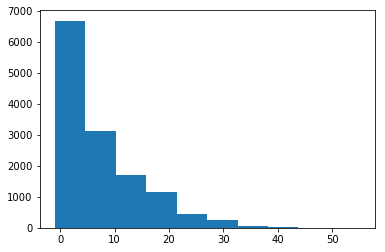

In [281]:
plt.hist(qbagg['FPoints'].map(int).values)
plt.show()

In [1192]:
def gen_notz(dat):   
    ## z-score all relevant vars:
    dat_z = pd.DataFrame()
    
    #dat_z['Year'] = dat['Year']
    dat_z['G_Num'] = (dat['G_Num'])

    #dat_z['Att'] = (dat['Att'])
    #dat_z['Temp'] = (rna(dat['Temp']))
    #dat_z['Wind'] = (rna(dat['Wind']))
    
    dat_z['AgeNew'] = (dat['AgeNew'])    


    dat_z['FPoints_A'] = ((dat['FPoints_A']))
    dat_z['FPoints_4'] = dat['FPoints_4']
    dat_z['FPoints_10'] = dat['FPoints_10']
    
    #dat_z['OU'] = dat['O/U']

    #defense stats
    dat_z['DPtsA'] = dat['DPtsA']
    #dat_z['DFDA'] = (dat['DFDA'])
    dat_z['DPassYdsA'] = (dat['DPassYdsA'])
    #dat_z['DRushYdsA'] = (dat['DRushYdsA'])
    dat_z['DTdsA'] = (dat['DTdsA'])

    #binary vars??? 
    #dat_z['Time'] = (dat['Time'])
    dat_z['Dome'] = (dat['Dome'])
    #dat_z['Surface'] = (dat['Surface'])
    #dat_z['Home'] = (dat['Home'])
    dat_z['Start'] = (dat['Start'])
    
    dat_z['FPoints'] = dat['FPoints']
    
    return dat_z

In [1193]:
q = get_params(gen_notz(all_wrs_db))

In [1194]:
q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                FPoints   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     805.4
Date:                Mon, 02 Apr 2018   Prob (F-statistic):               0.00
Time:                        12:37:23   Log-Likelihood:                -58535.
No. Observations:               18305   AIC:                         1.171e+05
Df Residuals:                   18294   BIC:                         1.172e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6310      0.521      1.211      0.226        -0.391     1.653
G_Num         -0.0428      0.009     -4.505      0.000        -0.061    -0.024
AgeNew        -0.2186      0.015    -14.154      0.000        -0.249    -0.188
FPoints_A      0.5237      0.022     23.711      0.000         0.480     0.567
FPoints_4      0.1806      0.018     10.119      0.000         0.146     0.216
FPoints_10     0.1874      0.024      7.887      0.000         0.141     0.234
DPtsA          0.0538      0.011      5.010      0.000         0.033     0.075
DPassYdsA      0.0170      0.001     13.448      0.000         0.015     0.019
DTdsA          0.2315      0.075      3.070      0.002         0.084     0.379
Dome          -0.4366      0.099     -4.424      0.000        -0.630    -0.243
Start          1.8421      0.105     17.622      0.000         1.637     2.047
==============================================================================
Omnibus:                     3362.074   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6829.225
Skew:                           1.102   Prob(JB):                         0.00
Kurtosis:                       5.024   Cond. No.                     2.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1195]:
for table in q.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     FPoints      & \textbf{  R-squared:         } &     0.306  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.305  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     805.4  \\
\textbf{Date:}             & Mon, 02 Apr 2018 & \textbf{  Prob (F-statistic):} &     0.00   \\
\textbf{Time:}             &     12:37:26     & \textbf{  Log-Likelihood:    } &   -58535.  \\
\textbf{No. Observations:} &       18305      & \textbf{  AIC:               } & 1.171e+05  \\
\textbf{Df Residuals:}     &       18294      & \textbf{  BIC:               } & 1.172e+05  \\
\textbf{Df Model:}         &          10      & \textbf{                     } &            \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabu

In [1064]:
## z-score dbase ???

def z(s):
    m = s.mean()
    sig = s.std()
    if sig == 0.:
        a = s.map(lambda x: float('nan'))
    else:
        a = s.map(lambda x: (x-m)/sig)
    return a
def rna(s):
    return s.replace(float('nan'),s.mean())


def gen_z(dat):   
    ## z-score all relevant vars:
    dat_z = pd.DataFrame()
    dat_z['Year'] = dat['Year']

    dat_z['G_Num'] = z(dat['G_Num'])
    dat_z['Wind'] = z(rna(dat['Wind']))
    dat_z['AgeNew'] = z(dat['AgeNew'])    

    dat_z['Att'] = z(dat['Att'])
    dat_z['Temp'] = z(rna(dat['Temp']))
    
    dat_z['AgeNew'] = z(dat['AgeNew'])    

    dat_z['FPoints_A'] = z(dat['FPoints_A'])
    dat_z['FPoints_4'] = z(dat['FPoints_4'])
    dat_z['FPoints_10'] = z(dat['FPoints_10'])
    
    #if pos not in ['rb']:
    #    dat_z['OU'] = z(dat['O/U'])
    
    #defense stats
    dat_z['DPtsA'] = z(dat['DPtsA'])
    dat_z['DPassYdsA'] = z(dat['DPassYdsA'])
    dat_z['DRushYdsA'] = z(dat['DRushYdsA'])
    dat_z['DTdsA'] = z(dat['DTdsA'])

    #binary vars??? 
    def b(v):
        if v == 1:
            return 3.92
        else:
            return 0
    def g_b(s):
        return s.map(b)
    dat_z['Time'] = g_b(dat['Time'])
    dat_z['Dome'] = g_b(dat['Dome'])
    dat_z['Surface'] = g_b(dat['Surface'])
    dat_z['Home'] = g_b(dat['Home'])
    dat_z['Start'] = g_b(dat['Start'])
    
    dat_z['FPoints'] = dat['FPoints']
    
    return dat_z


In [964]:
#qb_params = get_params(gen_z(all_qbs_db))#.summary()

In [977]:
#rb_params = get_params(gen_z(all_rbs_db))

In [1000]:
#wr_params = get_params(gen_z(all_wrs_db))

In [1011]:
#wr_params2 = get_params(gen_z(all_wrs_db))

In [1029]:
#qb_params2 = get_params(gen_z(all_qbs_db))

In [1049]:
#rb_params2 = get_params(gen_z(all_rbs_db))

In [1048]:
#rb_params2.summary()

In [767]:
#qb_params.summary()

In [1047]:
for table in rb_params2.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     FPoints      & \textbf{  R-squared:         } &     0.418  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.417  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     732.8  \\
\textbf{Date:}             & Sun, 01 Apr 2018 & \textbf{  Prob (F-statistic):} &     0.00   \\
\textbf{Time:}             &     22:31:17     & \textbf{  Log-Likelihood:    } &   -36027.  \\
\textbf{No. Observations:} &       11238      & \textbf{  AIC:               } & 7.208e+04  \\
\textbf{Df Residuals:}     &       11226      & \textbf{  BIC:               } & 7.217e+04  \\
\textbf{Df Model:}         &          11      & \textbf{                     } &            \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabu

In [288]:
def home(s):
    return (s != '@')

In [637]:
def get_o(s):
    try:
        a = float(s[0:4])
    except:
        a = float('nan')
    return  a
    

In [308]:
for i in range(len(qbs)):
    qb_dict[qbs[i]]['Home'] = qb_dict[qbs[i]]['@'].apply(home)

1

In [376]:
for i in range(len(qbs)):
    qb_dict[qbs[i]]['G_Num'] = qb_dict[qbs[i]]['G#'].apply(int)
for i in range(len(rbs)):
    rb_dict[rbs[i]]['G_Num'] = rb_dict[rbs[i]]['G#'].apply(int)
for i in range(len(wrs)):
    wr_dict[wrs[i]]['G_Num'] = wr_dict[wrs[i]]['G#'].apply(int)

In [309]:
for i in range(len(rbs)):
    rb_dict[rbs[i]]['Home'] = rb_dict[rbs[i]]['@'].apply(home)

In [310]:
for i in range(len(wrs)):
    wr_dict[wrs[i]]['Home'] = wr_dict[wrs[i]]['@'].apply(home)

In [333]:
for i in range(len(qbs[0:30])):
    try:
        qb_dict[qbs[i]]['Over/Under'].apply(get_o)
    except:
        print qbs[i]

/players/C/CollKe00.htm
/players/K/KitnJo00.htm


In [331]:
rb_dict[rbs[100]].columns.values

array(['Rk', 'Year', 'Date', 'G#', 'Age', 'TM', '@', 'Opp', 'Result',
       'Att_R', 'Yds_R', 'Y/A_R', 'TD_R', 'Tgt_W', 'Rec_W', 'Yds_W',
       'Y/R_W', 'TD_W', 'Ctch%_W', 'Y/Tgt_W', 'Time', 'Stadium', 'Att',
       'Dome', 'Surface', 'Vegas', 'Over/Under', 'Weather', 'Temp', 'Wind',
       'Start', 'VisRAtt', 'VisRYds', 'VisRTds', 'HomeRAtt', 'HomeRYds',
       'HomeRTds', 'VisPCmp', 'VisPAtt', 'VisPYds', 'VisPTds', 'VisPInt',
       'HomePCmp', 'HomePAtt', 'HomePYds', 'HomePTds', 'HomePInt', 'G_Num',
       'FPoints', 'Att_R_A', 'Yds_P_A', 'TD_P_A', 'FPoints_A', 'Rec_W_A',
       'Yds_W_A', 'TD_W_A', 'Tgt_P_A', 'DPtsA', 'DFDA', 'DTotYdsA',
       'DPassYdsA', 'DRushYdsA', 'DTdsA', 'DDEX', 'Home'], dtype=object)

In [696]:
##Get regression weights

## have to use training set???
all_qbs = []
for i in range(len(qbs)):
    all_qbs.append(qb_dict[qbs[i]])
all_qbs_db = pd.concat(all_qbs)

all_rbs = []
for i in range(len(rbs)):
    all_rbs.append(rb_dict[rbs[i]])
all_rbs_db = pd.concat(all_rbs)
    
all_wrs = []
for i in range(len(wrs)):
    all_wrs.append(wr_dict[wrs[i]])
all_wrs_db = pd.concat(all_wrs)
    

def get_params(db):
    cols = list(db.columns.values)
    cols.remove('FPoints')
    myformula = 'FPoints~'+'+'.join(cols)
    model = sm.ols(formula=myformula,data=db).fit()
    return model

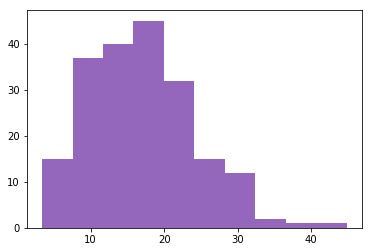

In [1147]:
plt.hist(qb_dict['/players/R/RoetBe00.htm']['FPoints'])
plt.show()

In [1136]:
all_rbs_db['FPoints'].mean()

7.36506670641722

In [313]:
qb_params = get_params(gen_z(all_qbs_db)).params

In [711]:
qb_params = get_params(gen_notz(all_qbs_db))
rb_params = get_params(gen_notz(all_rbs_db))
wr_params = get_params(gen_notz(all_wrs_db))

In [628]:
def get_ages(db):
    db['AgeNew'] = db['Age'].map(lambda x: x[0:2])

In [701]:
all_qbs_db['AgeNew'] = all_qbs_db['Age'].map(lambda x: int(x[0:2]))
all_rbs_db['AgeNew'] = all_rbs_db['Age'].map(lambda x: int(x[0:2]))
all_wrs_db['AgeNew'] = all_wrs_db['Age'].map(lambda x: int(x[0:2]))

In [795]:
for qb in qbs:
    qb_dict[qb]['AgeNew'] = qb_dict[qb]['Age'].map(lambda x: int(x[0:2]))

In [796]:
for rb in rbs:
    rb_dict[rb]['AgeNew'] = rb_dict[rb]['Age'].map(lambda x: int(x[0:2]))

In [797]:
for wr in wrs:
    wr_dict[wr]['AgeNew'] = wr_dict[wr]['Age'].map(lambda x: int(x[0:2]))

In [702]:
all_qbs_db['O/U'] = all_qbs_db['Over/Under'].map(lambda x: get_o(x))
all_rbs_db['O/U'] = all_rbs_db['Over/Under'].map(lambda x: get_o(x))
all_wrs_db['O/U'] = all_wrs_db['Over/Under'].map(lambda x: get_o(x))


In [703]:
all_wrs_db.to_csv('all_wrs.csv',encoding = 'utf-8',index=False)

In [704]:
all_rbs_db.to_csv('all_rbs.csv',encoding = 'utf-8',index=False)

In [706]:
all_qbs_db.to_csv('all_qbs.csv',encoding = 'utf-8',index=False)

In [913]:
get_params(gen_z(all_qbs_db)).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                FPoints   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     412.2
Date:                Sun, 01 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:29:27   Log-Likelihood:                -26929.
No. Observations:                8249   AIC:                         5.390e+04
Df Residuals:                    8230   BIC:                         5.403e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    264.3197     32.378      8.164      0.000       200.850   327.789
Year          -0.1249      0.016     -7.755      0.000        -0.156    -0.093
G_Num         -0.1536      0.084     -1.826      0.068        -0.319     0.011
Att            0.0762      0.072      1.063      0.288        -0.064     0.217
Temp          -0.0390      0.086     -0.456      0.649        -0.207     0.129
Wind          -0.3489      0.071     -4.931      0.000        -0.488    -0.210
AgeNew        -0.2541      0.075     -3.403      0.001        -0.400    -0.108
FPoints_A      2.8598      0.091     31.550      0.000         2.682     3.037
DPtsA          0.8136      0.116      7.029      0.000         0.587     1.040
DFDA          -0.1687      0.139     -1.214      0.225        -0.441     0.104
DPassYdsA      1.1927      0.141      8.437      0.000         0.916     1.470
DRushYdsA     -0.1917      0.113     -1.693      0.091        -0.414     0.030
DTdsA          0.0539      0.101      0.532      0.595        -0.145     0.252
DDEX          -0.6123      0.175     -3.493      0.000        -0.956    -0.269
Time           0.0233      0.071      0.327      0.744        -0.116     0.163
Dome          -0.0290      0.078     -0.373      0.710        -0.182     0.124
Surface        0.0724      0.079      0.919      0.358        -0.082     0.227
Home           0.2885      0.070      4.128      0.000         0.151     0.425
Start          3.5043      0.089     39.433      0.000         3.330     3.679
==============================================================================
Omnibus:                      230.831   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.423
Skew:                           0.373   Prob(JB):                     8.51e-59
Kurtosis:                       3.472   Cond. No.                     9.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [712]:
for table in qb_params.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     FPoints      & \textbf{  R-squared:         } &     0.452  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.451  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     287.8  \\
\textbf{Date:}             & Sat, 31 Mar 2018 & \textbf{  Prob (F-statistic):} &     0.00   \\
\textbf{Time:}             &     16:53:57     & \textbf{  Log-Likelihood:    } &   -22946.  \\
\textbf{No. Observations:} &        6995      & \textbf{  AIC:               } & 4.593e+04  \\
\textbf{Df Residuals:}     &        6974      & \textbf{  BIC:               } & 4.608e+04  \\
\textbf{Df Model:}         &          20      & \textbf{                     } &            \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabu

In [342]:
qb_dict[qbs[1]].columns.values

array(['Rk', 'Year', 'Date', 'G#', 'Age', 'TM', '@', 'Opp', 'Result', 'GS',
       'Cmp_P', 'Att_P', 'Cmp%_P', 'Yds_P', 'TD_P', 'Int_P', 'Rate_P',
       'Sk_p', 'Sk_Yds_P', 'Y/A_P', 'AY/A_P', 'Att_R', 'Yds_R', 'Y/A_R',
       'TD_R', 'Time', 'Stadium', 'Att', 'Dome', 'Surface', 'Vegas',
       'Over/Under', 'Weather', 'Temp', 'Wind', 'Start', 'VisRAtt',
       'VisRYds', 'VisRTds', 'HomeRAtt', 'HomeRYds', 'HomeRTds', 'VisPCmp',
       'VisPAtt', 'VisPYds', 'VisPTds', 'VisPInt', 'HomePCmp', 'HomePAtt',
       'HomePYds', 'HomePTds', 'HomePInt', 'G_Num', 'FPoints', 'FPoints_H',
       'Cmp_P_A', 'Att_P_A', 'Yds_P_A', 'TD_P_A', 'Att_R_A', 'FPoints_A',
       'DPtsA', 'DFDA', 'DTotYdsA', 'DPassYdsA', 'DRushYdsA', 'DTdsA',
       'DDEX', 'Home', 'O/U'], dtype=object)

In [1055]:
wr_params2.params

Intercept     6.331330
G_Num        -0.193161
AgeNew       -0.673458
FPoints_A     1.939161
FPoints_4     0.917336
FPoints_10    0.857643
DPtsA         0.209571
DPassYdsA     0.711554
Dome         -0.111922
Start         0.470916
dtype: float64

In [1084]:
##needs to be modified

def get_sim(row1,row2,weights,n,option):
    if option == False:
        weights = {x: 1 for x in weights}
    #year = abs((row1['Year']-row2['Year']))
    #games = (abs(row1['G_Num']-row2['G_Num'])+17.*year)/(20.*17.)
    
    norm_weights = [(w/(sum(weights))) for w in weights]
    
    def smf(s):
        if math.isnan(row1[s]):
            return 0
        if math.isnan(row2[s]):
            return 0
        #return (1./(abs(row1[s] - row2[s])+k))*abs(weights[s])
        return (((3.92+1.)/(abs(row1[s]-row2[s])+1.)))*abs(norm_weights[s])
    
    def bn(s):
        if math.isnan(row1[s]):
            return 0
        if math.isnan(row2[s]):
            return 0
        if row1[s] == row2[s]:
            return 3.92*abs(norm_weight[s])
        else:
            return 0
        
    try:
        att = smf('Att')
    except:
        att = 0
    try:
        age = smf('AgeNew')
    except:
        age = 0
        
    #binary
    try:
        time = bn('Time')
    except:
        time = 0
    try:
        dome = bn('Dome')
    except:
        dome = 0
    try:
        surface = bn('Surface')
    except:
        surface = 0
    try:
        start = bn('Start')
    except:
        start = 0
    try:
        home = bn('Home')
    except:
        home = 0
        
    #notbinary

    try:
        temp = smf('Temp')
    except:
        temp = 0
    try:
        wind = smf('Wind')
    except:
        wind = 0
    try:
        dptsa = smf('DPtsA')
    except:
        dptsa = 0
    try:
        dpydsa = smf('DPassYdsA')
    except:
        dpydsa = 0
    try:
        drydsa = smf('DRushYdsA') 
    except:
        drydsa = 0
    try:
        dtdsa = smf('DTdsA')
    except:
        dtdsa = 0
    try:    
        ddex = smf('DDEX')
    except:
        ddex = 0
    try:
        fpoints_a = smf('FPoints_A')
    except:
        fpoints_a = 0
    try:
        fpoints_4 = smf('FPoints_4')
    except:
        fpoints_4 = 0
    try:
        fpoints_10 = smf('FPoints_10')
    except:
        fpoints_10 = 0
    
    if row1['Year'] == row2['Year']:
        tot_weight = 2
    else:
        tot_weight = 1


    
    tot = (age+fpoints_4+fpoints_10+att+time+dome+surface+temp+wind+start+
           home+dptsa+dpydsa+drydsa+dtdsa+ddex+fpoints_a)
    if math.isnan(tot):
        tot = 0
    return max(tot*tot_weight,1)

In [1083]:
qb_dict['/players/B/BreeDr00.htm'].query('(Year < 2012|(Year == 2011 & G_Num<=8))&Year>2008')

,Rk,Year,Date,G#,Age,TM,@,Opp,Result,GS,...,DFDA,DTotYdsA,DPassYdsA,DRushYdsA,DTdsA,DDEX,Home,FPoints_4,FPoints_10,AgeNew
108,109,2009,"<a href=""/boxscores/200909130nor.htm"">2009-09-...",1,30-241,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/det/2009.htm"">DET</a>","<a href=""/boxscores/200909130nor.htm"">W 45-27</a>",*,...,28.000000,515.000000,358.000000,157.000000,3.000000,-19.750000,True,17.790,19.310,30
109,110,2009,"<a href=""/boxscores/200909200phi.htm"">2009-09-...",2,30-248,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/phi/2009.htm"">PHI</a>","<a href=""/boxscores/200909200phi.htm"">W 48-22</a>",*,...,18.500000,295.000000,185.500000,109.500000,4.000000,10.035000,False,21.190,19.804,30
110,111,2009,"<a href=""/boxscores/200909270buf.htm"">2009-09-...",3,30-255,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/buf/2009.htm"">BUF</a>","<a href=""/boxscores/200909270buf.htm"">W 27-7</a>",*,...,22.666667,390.666667,273.333333,117.333333,1.333333,2.346667,False,26.220,22.712,30
111,112,2009,"<a href=""/boxscores/200910040nor.htm"">2009-10-...",4,30-262,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/nyj/2009.htm"">NYJ</a>","<a href=""/boxscores/200910040nor.htm"">W 24-10</a>",*,...,16.000000,277.750000,177.500000,100.250000,2.000000,10.747500,True,28.210,22.750,30
112,113,2009,"<a href=""/boxscores/200910180nor.htm"">2009-10-...",5,30-276,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/nyg/2009.htm"">NYG</a>","<a href=""/boxscores/200910180nor.htm"">W 48-27</a>",*,...,13.000000,214.400000,104.800000,109.600000,2.200000,8.914000,True,24.695,21.230,30
113,114,2009,"<a href=""/boxscores/200910250mia.htm"">2009-10-...",6,30-283,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/mia/2009.htm"">MIA</a>","<a href=""/boxscores/200910250mia.htm"">W 46-34</a>",*,...,17.333333,320.166667,233.500000,86.666667,1.333333,-3.673333,False,19.110,20.696,30
114,115,2009,"<a href=""/boxscores/200911020nor.htm"">2009-11-...",7,30-291,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/atl/2009.htm"">ATL</a>","<a href=""/boxscores/200911020nor.htm"">W 35-27</a>",*,...,20.428571,378.142857,256.428571,121.714286,2.428571,-3.872857,True,17.620,20.940,30
115,116,2009,"<a href=""/boxscores/200911080nor.htm"">2009-11-...",8,30-297,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/car/2009.htm"">CAR</a>","<a href=""/boxscores/200911080nor.htm"">W 30-20</a>",*,...,17.625000,303.875000,181.750000,122.125000,1.875000,1.886250,True,18.090,21.778,30
116,117,2009,"<a href=""/boxscores/200911150ram.htm"">2009-11-...",9,30-304,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/ram/2009.htm"">STL</a>","<a href=""/boxscores/200911150ram.htm"">W 28-23</a>",*,...,21.888889,378.555556,236.222222,142.333333,1.333333,-7.911111,False,21.075,22.020,30
117,118,2009,"<a href=""/boxscores/200911220tam.htm"">2009-11-...",10,30-311,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/tam/2009.htm"">TAM</a>","<a href=""/boxscores/200911220tam.htm"">W 38-7</a>",*,...,20.400000,378.300000,209.400000,168.900000,1.600000,-5.338000,False,23.200,22.142,30


In [1113]:

def get_conditional(db,game,option,pos):
    
    yr = int(game['Year'])
    gm = int(game['G_Num'])
    l = int(yr-3)
    #subset data up to and including game in question
    #dat = db[(db['Year'] < yr) |((db['Year'] == yr) & (db['G#'] <= gm))]

    
    dat = db.query('(Year < @yr | (Year == @yr & G_Num <= @gm))&Year >= @l').reset_index()
    #db[(db['Year'] < yr) |((db['Year'] == yr) & (db['G#'] <= gm))]
    
    
    ## z-score all relevant vars:
    
    dat_pred = gen_z(dat)[0:-1].copy()
    
    
    
    if pos == 'qb':
        weights = qb_params2.params
    elif pos == 'rb':
        weights = rb_params2.params
    else:
        weights = wr_params2.params
     
    weight = []
    for i in range(len(dat_pred['FPoints'])):     
        weight.append(get_sim(dat_pred.iloc[i],gen_z(dat).iloc[-1],weights,4,option))
    dat_pred['Weight'] = weight
    
    #dat_pred['Weight'] = dat_pred['Weight'].replace(float('nan'),0.)
        
    
    # Build weighted histogram
      
    weighted  = []
    for i in range(len(dat_pred['Weight'])):
        n = int(round(dat_pred['Weight'][i]))
        weighted = weighted+[dat_pred['FPoints'][i]]*n

       
    db = pd.DataFrame()
    db['FPointsP'] = weighted
    
    
    #a, bins = np.histogram(dat_pred['FPoints'],weights=dat_pred['Weight'],density=True)
    #width = 0.7*(bins[1]-bins[0])
    #center = (bins[:-1] + bins[1:]) / 2
    return [db,yr,gm] #[a,center,width,dat_pred,dat]
       

In [349]:
## save final modified data to csvs
for i in range(len(qbs)):
    name = 'finaldat/qbs/'+qbs[i].replace('/','')+'.csv'
    qb_dict[qbs[i]].to_csv(name,encoding = 'utf-8',index=False)

In [350]:
for i in range(len(rbs)):
    name = 'finaldat/rbs/'+rbs[i].replace('/','')+'.csv'
    rb_dict[rbs[i]].to_csv(name,encoding = 'utf-8',index=False)

In [351]:
for i in range(len(wrs)):
    name = 'finaldat/wrs/'+wrs[i].replace('/','')+'.csv'
    wr_dict[wrs[i]].to_csv(name,encoding = 'utf-8',index=False)

In [412]:
for i in range(len(qbs)):
    try:
        qb_dict[qbs[i]]['Att'][0]
    except:
        game_scraper(qbs[i],qb_dict,'qb')

In [1103]:
c = qb_dict[a][qb_dict[a]['Year']>2008]
yr = 2012
gm = 9
c.query('(Year < @yr | (Year == @yr & G_Num <= @gm))')

,Rk,Year,Date,G#,Age,TM,@,Opp,Result,GS,...,DFDA,DTotYdsA,DPassYdsA,DRushYdsA,DTdsA,DDEX,Home,FPoints_4,FPoints_10,AgeNew
108,109,2009,"<a href=""/boxscores/200909130nor.htm"">2009-09-...",1,30-241,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/det/2009.htm"">DET</a>","<a href=""/boxscores/200909130nor.htm"">W 45-27</a>",*,...,28.000000,515.000000,358.000000,157.000000,3.000000,-19.750000,True,17.790,19.310,30
109,110,2009,"<a href=""/boxscores/200909200phi.htm"">2009-09-...",2,30-248,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/phi/2009.htm"">PHI</a>","<a href=""/boxscores/200909200phi.htm"">W 48-22</a>",*,...,18.500000,295.000000,185.500000,109.500000,4.000000,10.035000,False,21.190,19.804,30
110,111,2009,"<a href=""/boxscores/200909270buf.htm"">2009-09-...",3,30-255,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/buf/2009.htm"">BUF</a>","<a href=""/boxscores/200909270buf.htm"">W 27-7</a>",*,...,22.666667,390.666667,273.333333,117.333333,1.333333,2.346667,False,26.220,22.712,30
111,112,2009,"<a href=""/boxscores/200910040nor.htm"">2009-10-...",4,30-262,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/nyj/2009.htm"">NYJ</a>","<a href=""/boxscores/200910040nor.htm"">W 24-10</a>",*,...,16.000000,277.750000,177.500000,100.250000,2.000000,10.747500,True,28.210,22.750,30
112,113,2009,"<a href=""/boxscores/200910180nor.htm"">2009-10-...",5,30-276,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/nyg/2009.htm"">NYG</a>","<a href=""/boxscores/200910180nor.htm"">W 48-27</a>",*,...,13.000000,214.400000,104.800000,109.600000,2.200000,8.914000,True,24.695,21.230,30
113,114,2009,"<a href=""/boxscores/200910250mia.htm"">2009-10-...",6,30-283,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/mia/2009.htm"">MIA</a>","<a href=""/boxscores/200910250mia.htm"">W 46-34</a>",*,...,17.333333,320.166667,233.500000,86.666667,1.333333,-3.673333,False,19.110,20.696,30
114,115,2009,"<a href=""/boxscores/200911020nor.htm"">2009-11-...",7,30-291,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/atl/2009.htm"">ATL</a>","<a href=""/boxscores/200911020nor.htm"">W 35-27</a>",*,...,20.428571,378.142857,256.428571,121.714286,2.428571,-3.872857,True,17.620,20.940,30
115,116,2009,"<a href=""/boxscores/200911080nor.htm"">2009-11-...",8,30-297,"<a href=""/teams/nor/2009.htm"">NOR</a>",NaN,"<a href=""/teams/car/2009.htm"">CAR</a>","<a href=""/boxscores/200911080nor.htm"">W 30-20</a>",*,...,17.625000,303.875000,181.750000,122.125000,1.875000,1.886250,True,18.090,21.778,30
116,117,2009,"<a href=""/boxscores/200911150ram.htm"">2009-11-...",9,30-304,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/ram/2009.htm"">STL</a>","<a href=""/boxscores/200911150ram.htm"">W 28-23</a>",*,...,21.888889,378.555556,236.222222,142.333333,1.333333,-7.911111,False,21.075,22.020,30
117,118,2009,"<a href=""/boxscores/200911220tam.htm"">2009-11-...",10,30-311,"<a href=""/teams/nor/2009.htm"">NOR</a>",@,"<a href=""/teams/tam/2009.htm"">TAM</a>","<a href=""/boxscores/200911220tam.htm"">W 38-7</a>",*,...,20.400000,378.300000,209.400000,168.900000,1.600000,-5.338000,False,23.200,22.142,30


In [1119]:
a = '/players/B/BreeDr00.htm'
r = get_conditional((qb_dict[a]),(qb_dict[a][qb_dict[a]['Year']==2012]).reset_index().iloc[9],True,'qb')

In [1122]:
qb_dict[a][qb_dict[a]['Year']==2012].reset_index().iloc[9]['FPoints']

20.759999999999998

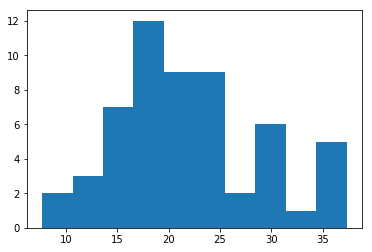

In [1120]:
plt.hist(r[0]['FPointsP'])
plt.show()

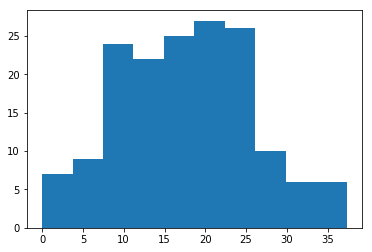

In [1115]:
plt.hist(qb_dict[a].query('Year < 2012| Year == 2012 & G_Num < 8')['FPoints'])
plt.show()

In [394]:
yr = 2011
gm = 10
dat = qb_dict[a].query('Year < @yr | (Year == @yr & G_Num <= @gm)')
dat_pred = gen_z(dat)[5:-1].copy()
weights = qb_params  
weight = []
for i in range(len(dat_pred['FPoints'])):     
    weight.append(get_sim(dat_pred.iloc[i],gen_z(dat).iloc[-1],weights,4,True))
dat_pred['Weight'] = weight
weighted  = []
for i in range(len(dat_pred['Weight'])):
    n = int(round(dat_pred['Weight'][i]))
    weighted = weighted+[dat_pred['FPoints'][i]]*n


db = pd.DataFrame()
db['FPoints'] = weighted

In [413]:
ls = ['/players/C/CollKe00.htm','/players/K/KitnJo00.htm','/players/H/HassMa00.htm','/players/B/BatcCh00.htm',
     '/players/M/McNaDo00.htm','/players/B/BrunMa00.htm']

In [423]:
qb_dict[ls[0]] = clean(pd.read_csv('qbs/'+ls[0].replace('/','')+'.csv'))

TypeError: 'module' object is not callable

In [425]:
for qb in ls:
    try:
        qb_dict[qb] = clean(pd.read_csv('qbs/'+qb.replace('/','')+'.csv'))
    except:
        print qb

In [604]:
qb = '/players/B/BradTo00.htm'

In [609]:
r = get_conditional(qb_dict[qb],(qb_dict[qb][qb_dict[qb]['Year'] > 2010]).reset_index().iloc[10],True,'qb')

In [612]:
r[0]['Actual'][1]

29.239999999999998

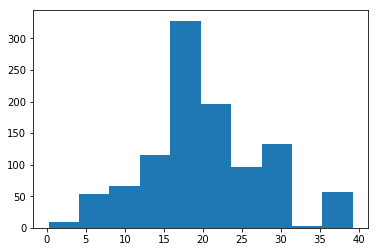

In [611]:
plt.hist(r[0]['FPointsP'])
plt.show()

In [610]:
r[0]['Actual'] = [qb_dict[qb][qb_dict[qb]['Year'] > 2010].reset_index().iloc[10]['FPoints']]*len(r[0]['FPointsP'])

In [488]:
from datetime import datetime
from datetime import date
from datetime import timedelta

In [503]:
start_dates = {}
start_dates[2011] = date(2011,9,8) # thurs
start_dates[2012] = date(2012,9,5) # wednesday
start_dates[2013] = date(2013,9,5) # thurs
start_dates[2014] = date(2014,9,4) # thurs
start_dates[2015] = date(2015,9,10) # thurs
start_dates[2016] = date(2016,9,8) # thurs
start_dates[2017] = date(2017,9,7) # thurs
ds = {}
ds[2011] = {}
ds[2012] = {}
ds[2013] = {}
ds[2014] = {}
ds[2015] = {}
ds[2016] = {}
ds[2017] = {}

In [533]:
for yr in range(2011,2018):
    for wk in range(1,18):
        start = start_dates[yr] + timedelta(days=(7*(wk-1)))
        end = start + timedelta(days=5)
        ds[yr][wk] = [start,end]

In [534]:
ds[2017][17]

[datetime.date(2017, 12, 28), datetime.date(2018, 1, 2)]

In [508]:
d = datetime.strptime(qb_dict[qbs[1]]['Date'][50][38:48],'%Y-%m-%d').date()
d2 = datetime.strptime(qb_dict[qbs[1]]['Date'][1][38:48],'%Y-%m-%d')

In [547]:
def get_wk(row):
    d = datetime.strptime(row['Date'][38:48],'%Y-%m-%d').date()
    e = row['G_Num']
    yr = row['Year']
    if (ds[yr][e][1]>= d): 
        return e
    else:
        return e+1


In [1129]:
wr_dict['/players/E/EdelJu00.htm']['FPoints']

0      13.8
1       3.5
2       1.7
3       3.0
4       7.3
5       8.4
6       4.1
7       0.0
8       0.0
9       3.3
10     15.3
11      1.1
12      2.3
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      8.7
26      1.4
27      0.0
28      1.0
29      1.6
       ... 
73      7.5
74     14.4
75      8.3
76     24.1
77     18.3
78     15.2
79     27.2
80     12.5
81     20.0
82     14.0
83      7.9
84     23.6
85     14.0
86      7.3
87     10.1
88     11.1
89      5.8
90      2.1
91      6.0
92      5.0
93     10.5
94     11.7
95     13.4
96     17.7
97     12.3
98     14.1
99     10.8
100    10.5
101    11.4
102    25.1
Name: FPoints, dtype: float64

In [545]:
qb_dict['/players/G/GaroJi00.htm']['TM'][0][16:19]

'nwe'

In [1125]:
for qb in qbs:
    for i in range(len(qb_dict[qb][qb_dict[qb]['Year'] > 2010])):
        try:
            g = (qb_dict[qb][qb_dict[qb]['Year'] > 2010]).reset_index().iloc[i]
            tm = g['TM'][16:19]
            r = get_conditional(qb_dict[qb],g,True,'qb')
            name = 'dists4/qbs/'+str(r[1])+'/'+str(get_wk(g))+'/'+tm+'_'+str(qb).replace('/','')[:-6]+'.csv'
            r[0]['Actual'] = [g['FPoints']]*len(r[0]['FPointsP'])
            r[0].to_csv(name,encoding='utf-8',index=False)
            time.sleep(0.01)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            raise
    time.sleep(1)

In [1126]:
for rb in rbs:
    for i in range(len(rb_dict[rb][rb_dict[rb]['Year'] > 2010])):
        try:
            g = (rb_dict[rb][rb_dict[rb]['Year'] > 2010]).reset_index().iloc[i]
            tm = g['TM'][16:19]
            r = get_conditional(rb_dict[rb],g,True,'rb')
            name = 'dists4/rbs/'+str(r[1])+'/'+str(get_wk(g))+'/'+tm+'_'+str(rb).replace('/','')[:-6]+'.csv'
            r[0]['Actual'] = [g['FPoints']]*len(r[0]['FPointsP'])
            r[0].to_csv(name,encoding='utf-8',index=False)
            time.sleep(0.01)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print rb
    time.sleep(1)

In [1127]:
time.sleep(60)
for wr in wrs:
    for i in range(len(wr_dict[wr][wr_dict[wr]['Year'] > 2010])):
        try:
            g = (wr_dict[wr][wr_dict[wr]['Year'] > 2010]).reset_index().iloc[i]
            tm = g['TM'][16:19]
            r = get_conditional(wr_dict[wr],g,True,'wr')
            name = 'dists4/wrs/'+str(r[1])+'/'+str(get_wk(g))+'/'+tm+'_'+str(wr).replace('/','')[:-6]+'.csv'
            r[0]['Actual'] = [g['FPoints']]*len(r[0]['FPointsP'])
            r[0].to_csv(name,encoding='utf-8',index=False)
            time.sleep(0.01)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print wr
    time.sleep(2)

In [616]:
wr = '/players/S/ShorCe00.htm'
g = (wr_dict[wr][wr_dict[wr]['Year'] > 2010]).reset_index().iloc[0]
r = get_conditional(wr_dict[wr],g,True,'wr')


    




In [618]:
g

index                                                         0
Rk                                                            1
Year                                                       2011
Date          <a href="/boxscores/201109110jax.htm">2011-09-...
G#                                                            1
Age                                                      23-263
TM                        <a href="/teams/jax/2011.htm">JAX</a>
@                                                           NaN
Opp                       <a href="/teams/oti/2011.htm">TEN</a>
Result        <a href="/boxscores/201109110jax.htm">W 16-14</a>
Tgt_W                                                         0
Rec_W                                                         0
Yds_W                                                         0
Y/R_W                                                       NaN
TD_W                                                          0
Ctch%_W                                 

In [ ]:
def convert(s):
    s.plit(',')

In [366]:
len(qbs)

145

In [552]:
qb_dict[qbs[1]][qb_dict[qbs[1]]['Year'] == 2011].reset_index()

,index,Rk,Year,Date,G#,Age,TM,@,Opp,Result,...,HomePYds,HomePTds,HomePInt,G_Num,Cmp_P_A,Att_P_A,Yds_P_A,TD_P_A,Att_R_A,FPoints_A
0,145,146,2011,"<a href=""/boxscores/201109120mia.htm"">2011-09-...",1,34-040,"<a href=""/teams/nwe/2011.htm"">NWE</a>",@,"<a href=""/teams/mia/2011.htm"">MIA</a>","<a href=""/boxscores/201109120mia.htm"">W 38-24</a>",...,416,2,1,1,20.739726,32.589041,4.178082,0.047945,2.308219,16.201644
1,146,147,2011,"<a href=""/boxscores/201109180nwe.htm"">2011-09-...",2,34-046,"<a href=""/teams/nwe/2011.htm"">NWE</a>",[],"<a href=""/teams/sdg/2011.htm"">SDG</a>","<a href=""/boxscores/201109180nwe.htm"">W 35-21</a>",...,423,3,0,2,20.809524,32.639456,4.170068,0.047619,2.306122,16.290204
2,147,148,2011,"<a href=""/boxscores/201109250buf.htm"">2011-09-...",3,34-053,"<a href=""/teams/nwe/2011.htm"">NWE</a>",@,"<a href=""/teams/buf/2011.htm"">BUF</a>","<a href=""/boxscores/201109250buf.htm"">L 31-34</a>",...,369,2,2,3,20.871622,32.722973,4.175676,0.047297,2.297297,16.342162
3,148,149,2011,"<a href=""/boxscores/201110020rai.htm"">2011-10-...",4,34-060,"<a href=""/teams/nwe/2011.htm"">NWE</a>",@,"<a href=""/teams/rai/2011.htm"">OAK</a>","<a href=""/boxscores/201110020rai.htm"">W 31-19</a>",...,344,1,2,4,20.838926,32.704698,4.140940,0.046980,2.288591,16.346174
4,149,150,2011,"<a href=""/boxscores/201110090nwe.htm"">2011-10-...",5,34-067,"<a href=""/teams/nwe/2011.htm"">NWE</a>",[],"<a href=""/teams/nyj/2011.htm"">NYJ</a>","<a href=""/boxscores/201110090nwe.htm"">W 30-21</a>",...,321,1,1,5,20.860000,32.706667,4.133333,0.046667,2.280000,16.338133
5,150,151,2011,"<a href=""/boxscores/201110160nwe.htm"">2011-10-...",6,34-074,"<a href=""/teams/nwe/2011.htm"">NWE</a>",[],"<a href=""/teams/dal/2011.htm"">DAL</a>","<a href=""/boxscores/201110160nwe.htm"">W 20-16</a>",...,289,2,2,6,20.900662,32.761589,4.218543,0.046358,2.291391,16.344238
6,151,152,2011,"<a href=""/boxscores/201110300pit.htm"">2011-10-...",7,34-088,"<a href=""/teams/nwe/2011.htm"">NWE</a>",@,"<a href=""/teams/pit/2011.htm"">PIT</a>","<a href=""/boxscores/201110300pit.htm"">L 17-25</a>",...,365,2,1,7,20.921053,32.776316,4.190789,0.046053,2.276316,16.341447
7,152,153,2011,"<a href=""/boxscores/201111060nwe.htm"">2011-11-...",8,34-095,"<a href=""/teams/nwe/2011.htm"">NWE</a>",[],"<a href=""/teams/nyg/2011.htm"">NYG</a>","<a href=""/boxscores/201111060nwe.htm"">L 20-24</a>",...,342,2,2,8,20.967320,32.882353,4.196078,0.045752,2.267974,16.353464
8,153,154,2011,"<a href=""/boxscores/201111130nyj.htm"">2011-11-...",9,34-102,"<a href=""/teams/nwe/2011.htm"">NWE</a>",@,"<a href=""/teams/nyj/2011.htm"">NYJ</a>","<a href=""/boxscores/201111130nyj.htm"">W 37-16</a>",...,306,1,2,9,21.000000,32.922078,4.181818,0.045455,2.272727,16.411948
9,154,155,2011,"<a href=""/boxscores/201111210nwe.htm"">2011-11-...",10,34-110,"<a href=""/teams/nwe/2011.htm"">NWE</a>",[],"<a href=""/teams/kan/2011.htm"">KAN</a>","<a href=""/boxscores/201111210nwe.htm"">W 34-3</a>",...,234,2,0,10,20.961290,32.883871,4.219355,0.045161,2.270968,16.424516


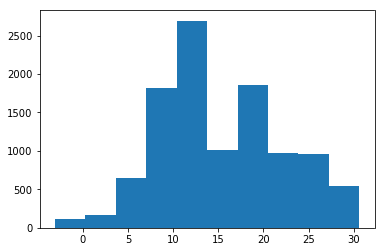

In [524]:
plt.hist(brady_dists[104]['FPoints'].values)
plt.show()

In [484]:
qb_params

{'Att': -0.124104,
 'DDEX': -1.185521,
 'DFDA': -0.53762,
 'DPassYdsA': 0.361678,
 'DPtsA': 2.000774,
 'DRushYdsA': -0.023282,
 'Dome': -0.082706,
 'FPoints_H': 2.355259,
 'G_Num': -0.077594,
 'Intercept': 13.138066,
 'Surface': -0.048526,
 'Temp': -0.201233,
 'Time': 0.327311,
 'Wind': -0.360226,
 'Year': -0.102718}

In [407]:
t = get_conditional(qb_dict[qbs[1]],qb_dict[qbs[1]].iloc[25],True)


8.04907350928


In [408]:
t.to_csv('test3.csv',encoding = 'utf-8',index=False)


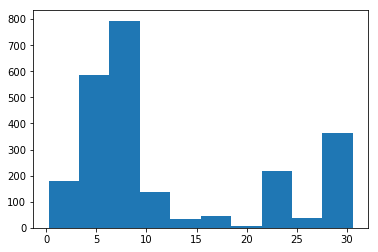

In [404]:
plt.hist(t)
plt.show()
to_csv('test2.csv',encoding = 'utf-8',index=False)


#plt.hist(t['FPoints'])#,density=True)
#plt.show()

8.04907350928
6.98


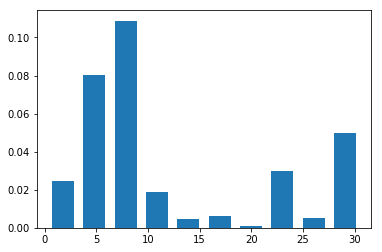

In [314]:
g = 25
m = center = get_conditional(qb_dict[qbs[1]],qb_dict[qbs[1]].iloc[g],True)
hist = m[0]
center = m[1]
width = m[2]

print qb_dict[qbs[1]].iloc[g]['FPoints']

plt.bar(center,hist,align='center',width=width)
plt.show()

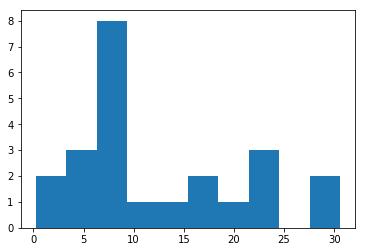

In [313]:
plt.hist(qb_dict[qbs[1]]['FPoints'][0:23])#,density=True)
plt.show()

15.78


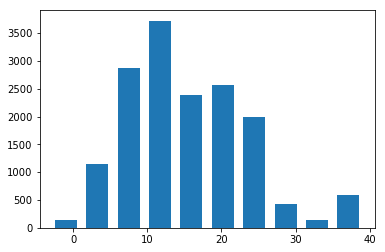

In [293]:
g = 120
m = get_conditional(qb_dict[qbs[1]],qb_dict[qbs[1]].iloc[g],True)
hist = m[0]
center = m[1]
width = m[2]

print qb_dict[qbs[1]].iloc[g]['FPoints']

plt.bar(center,hist,align='center',width=width)
plt.show()

In [227]:
db = qb_dict[qbs[1]]
yr = 2001
gm = 12
#db[(db['Year'] < yr) |((db['Year'] == yr) & (db['G#'] <= gm))]

#db.query('Year < @yr | (Year == @yr & G_Num <= @gm)')

,Rk,Year,Date,G#,Age,TM,@,Opp,Result,GS,...,VisPAtt,VisPYds,VisPTds,VisPInt,HomePCmp,HomePAtt,HomePYds,HomePTds,HomePInt,G_Num
0,1,2000,"<a href=""/boxscores/200011230det.htm"">2000-11-...",12,23-112,"<a href=""/teams/nwe/2000.htm"">NWE</a>",@,"<a href=""/teams/det/2000.htm"">DET</a>","<a href=""/boxscores/200011230det.htm"">L 9-34</a>",[],...,35,154,0,2,17,25,204,1,0,12
1,2,2001,"<a href=""/boxscores/200109230nwe.htm"">2001-09-...",2,24-051,"<a href=""/teams/nwe/2001.htm"">NWE</a>",[],"<a href=""/teams/nyj/2001.htm"">NYJ</a>","<a href=""/boxscores/200109230nwe.htm"">L 3-10</a>",[],...,28,137,0,0,23,38,205,0,2,2
2,3,2001,"<a href=""/boxscores/200109300nwe.htm"">2001-09-...",3,24-058,"<a href=""/teams/nwe/2001.htm"">NWE</a>",[],"<a href=""/teams/clt/2001.htm"">IND</a>","<a href=""/boxscores/200109300nwe.htm"">W 44-13</a>",*,...,43,253,1,3,13,23,168,0,0,3
3,4,2001,"<a href=""/boxscores/200110070mia.htm"">2001-10-...",4,24-065,"<a href=""/teams/nwe/2001.htm"">NWE</a>",@,"<a href=""/teams/mia/2001.htm"">MIA</a>","<a href=""/boxscores/200110070mia.htm"">L 10-30</a>",*,...,24,86,0,0,11,21,87,1,1,4
4,5,2001,"<a href=""/boxscores/200110140nwe.htm"">2001-10-...",5,24-072,"<a href=""/teams/nwe/2001.htm"">NWE</a>",[],"<a href=""/teams/sdg/2001.htm"">SDG</a>","<a href=""/boxscores/200110140nwe.htm"">W 29-26</a>",*,...,32,270,1,0,33,54,364,2,0,5
5,6,2001,"<a href=""/boxscores/200110210clt.htm"">2001-10-...",6,24-079,"<a href=""/teams/nwe/2001.htm"">NWE</a>",@,"<a href=""/teams/clt/2001.htm"">IND</a>","<a href=""/boxscores/200110210clt.htm"">W 38-17</a>",*,...,21,262,4,0,22,34,335,1,0,6
6,7,2001,"<a href=""/boxscores/200110280den.htm"">2001-10-...",7,24-086,"<a href=""/teams/nwe/2001.htm"">NWE</a>",@,"<a href=""/teams/den/2001.htm"">DEN</a>","<a href=""/boxscores/200110280den.htm"">L 20-31</a>",*,...,39,203,2,5,19,30,283,2,2,7
7,8,2001,"<a href=""/boxscores/200111040atl.htm"">2001-11-...",8,24-093,"<a href=""/teams/nwe/2001.htm"">NWE</a>",@,"<a href=""/teams/atl/2001.htm"">ATL</a>","<a href=""/boxscores/200111040atl.htm"">W 24-10</a>",*,...,31,250,3,0,10,29,151,1,1,8
8,9,2001,"<a href=""/boxscores/200111110nwe.htm"">2001-11-...",9,24-100,"<a href=""/teams/nwe/2001.htm"">NWE</a>",[],"<a href=""/teams/buf/2001.htm"">BUF</a>","<a href=""/boxscores/200111110nwe.htm"">W 21-11</a>",*,...,33,204,1,2,15,21,107,1,1,9
9,10,2001,"<a href=""/boxscores/200111180nwe.htm"">2001-11-...",10,24-107,"<a href=""/teams/nwe/2001.htm"">NWE</a>",[],"<a href=""/teams/ram/2001.htm"">STL</a>","<a href=""/boxscores/200111180nwe.htm"">L 17-24</a>",*,...,42,401,3,2,19,27,185,1,2,10


In [288]:
def get_sim(row1,row2,weights,n,option):
    if option == False:
        weights = {x: 1 for x in weights}
    k = .001
    #year = abs((row1['Year']-row2['Year']))
    #games = (abs(row1['G_Num']-row2['G_Num'])+17.*year)/(20.*17.)
    att = (1/(abs(row1['Att'] - row2['Att'])+k))*abs(weights['Att'])**2
    time =(1/(abs(row1['Time']-row2['Time'])+k))*abs(weights['Time'])**2
    dome = (1/(abs(row1['Dome']- row2 ['Dome'])+k))*abs(weights['Dome'])**2
    surface = (1/(abs(row1['Surface']-row2['Surface'])+k))*abs(weights['Surface'])**2
    #start = row1['start'] != row2['start']


    temp =(1/(abs(row1['Temp'] - row2['Temp'])+k))*abs(weights['Temp'])**2

    wind =(1/(abs(row1['Wind'] - row2['Wind'])+k))*abs(weights['Wind'])**2
    
    
    dptsa = (1/(abs(row1['DPtsA']-row2['DPtsA'])+k))*abs(weights['DPtsA'])**2
    
    dpydsa = (1/(abs(row1['DPassYdsA']-row2['DPassYdsA'])+k))*abs(weights['DPassYdsA'])**2
    drydsa = (1/(abs(row1['DRushYdsA']-row2['DRushYdsA'])+k))*abs(weights['DRushYdsA'])**2
    ddex = (1/(abs(row1['DDEX']-row2['DDEX'])+k))*abs(weights['DDEX'])**2
    
    fpoints_h = (1/(abs(row1['FPoints_H']-row2['FPoints_H'])+k))*abs(weights['FPoints_H'])**2
    


    
    tot = (att+time+dome+surface+temp+wind+dptsa+dpydsa+drydsa+ddex+fpoints_h)
    tot2 = dptsa+ddex+fpoints_h
    return tot

In [106]:
row1 = qb_dict[qbs[1]].iloc[100]
row2 = qb_dict[qbs[1]].iloc[200]

get_sim(row1,row2,qb_params)

/Users/dylanfarrell/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


70.76925

In [101]:
get_conditional(qb_dict[qbs[1]],qb_dict[qbs[1]][:-1])

ValueError: Can only compare identically-labeled Series objects

In [ ]:
    
    
    ##get regression weights, exclude last row
    
    frames = []
    for i in range(24):
        frames.append(qb_dict[qbs[i]])
        result = pd.concat(frames)
    dat_pred = dat_z[:-1]
    cols = list(dat_pred.columns.values)
    cols.remove('FPoints')
    myformula = 'FPoints~'+'+'.join(cols)
    print myformula

    result = sm.ols(formula=myformula,data=dat_pred,).fit()
    
    dat_pred.to_csv('test.csv',encoding = 'utf-8',index=False)
    
    return result

In [1149]:
qb_params = get_conditional(qbsub,qbsub.iloc[-1]).params

FPoints~Year+G_Num+Att+Temp+Wind+FPoints_H+DPtsA+DFDA+DPassYdsA+DRushYdsA+DDEX+Time+Dome+Surface


In [40]:
qb_params = {}

In [41]:
qb_params['Intercept'] = 13.138066
qb_params['Year'] = -0.102718
qb_params['G_Num'] = -0.077594
qb_params['Att'] = -0.124104
qb_params['Temp'] = -0.201233
qb_params['Wind'] = -0.360226
qb_params['FPoints_H'] = 2.355259
qb_params['DPtsA'] = 2.000774
qb_params['DFDA'] = -0.537620
qb_params['DPassYdsA'] = 0.361678
qb_params['DRushYdsA'] = -0.023282
qb_params['DDEX'] = -1.185521
qb_params['Time'] = 0.327311
qb_params['Dome'] = -0.082706
qb_params['Surface'] = -0.048526



In [ ]:
frames = []
for i in range(24):
    frames.append(qb_dict[qbs[i]])
result = pd.concat(frames)

In [1141]:
cols = list(qbagg.columns.values)
cols.remove('FPoints')
myformula = 'FPoints~'+'+'.join(cols)

result = sm.ols(formula=myformula,data=qbagg).fit()

PatsyError: comments are not allowed
    FPoints~@+AY/A_P+Age+Att+Att_P+Att_R+Att_Role+Att_Role_H+Cmp%_P+Cmp_P+Comp_Role+Comp_Role_H+DDEX+DFDA+DPassYdsA+DPtsA+DRushYdsA+DTdsA+DTotYdsA+Date+Dome+Dome2+FPoints_H+G#+GS+HomePAtt+HomePCmp+HomePInt+HomePTds+HomePYds+HomeRAtt+HomeRTds+HomeRYds+Int_P+Opp+Over/Under+Pass_away+Pass_home+Rate_P+Result+Rk+Rush_away+Rush_home+Sk_Yds_P+Sk_p+Stadium+Start+Surface+Surface2+TD_P+TD_R+TM+Tds_Role+Tds_Role_H+Temp+Test+Time+Top_away+Top_home+Vegas+VisPAtt+VisPCmp+VisPInt+VisPTds+VisPYds+VisRAtt+VisRTds+VisRYds+Weather+Wind+Y/A_P+Y/A_R+Yds_P+Yds_R+Yds_Role+Yds_Role_H+Year+start
                                                                                                                                                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [952]:
a = d['Att'].mean()
b = d['Att'].std()

In [961]:
headers

['Week',
 'Day',
 'Date',
 'Time',
 'Url',
 'W/L',
 'OT',
 'Rec',
 '@',
 'Opp',
 'PtsF',
 'PtsA',
 '1stD',
 'TotYd',
 'PassY',
 'RushY',
 'TO',
 '1stD_d',
 'TotYd_d',
 'PassY_d',
 'RushY_d',
 'TO_d',
 'OEx',
 'DEx',
 'SpTms']

In [959]:
(d['Att'].iloc[4]-a)/b

0.3312944349154211